In [50]:
import torch

import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

## DiamondsDataset with DropObj, Tensor, Normalize by transform.Compose

In [60]:
class DiamondsDataset(Dataset):
    def __init__(self, csv, transform=None):
        data = pd.read_csv(csv).iloc[:, 1:]
          
        self.transform = transform
        self.y = data['price']
        self.X = data.drop(columns='price')
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X.loc[idx,:], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [61]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop
    
    def __call__(self, sample):
        X, y = sample
        X = X.drop(labels=self.drop).astype(float)
        return X, y

In [62]:
class Normalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        
    def __call__(self, sample):
        inputs, targets = sample
        inputs.sub_(inputs.mean()).div_(inputs.std())
        return inputs, targets

In [63]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        X = torch.tensor(X.values, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        return X, y

In [64]:
data = pd.read_csv('diamonds.csv').iloc[:, 1:].select_dtypes(exclude=['object']).drop(columns='price')

X_mean = data.mean(axis=0).values
X_std = data.std(axis=0).values

In [65]:
from torchvision import transforms

drop = DropColsTransform(drop=['cut', 'color', 'clarity'])
normal = Normalize(X_mean, X_std)
to_tensor = ToTensorTransform()
dataset = DiamondsDataset('diamonds.csv', transforms.Compose([drop, to_tensor]))

In [66]:
train, test = random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(train, batch_size=256, shuffle=True)

In [67]:
model = nn.Sequential(
    
    nn.Linear(6, 8),
    nn.ReLU(),    
    nn.Linear(8, 3),
    nn.Linear(3, 1)
    
)
opt = torch.optim.Adam(model.parameters(),lr = 0.005, weight_decay=1e-4)
criterion = nn.MSELoss()
loss_list = []

In [71]:
for epoch in range(100):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = model(x)
        curr_loss = criterion(y_hat, y_.reshape(-1,1))
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 10 == 0:
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()}')
        
    

0 --loss--> 13923458.0
10 --loss--> 2314810.5
20 --loss--> 2284485.5
30 --loss--> 2259732.0
40 --loss--> 2234654.75
50 --loss--> 2214436.0
60 --loss--> 2206758.5
70 --loss--> 2195929.0
80 --loss--> 2172448.5
90 --loss--> 2169616.75


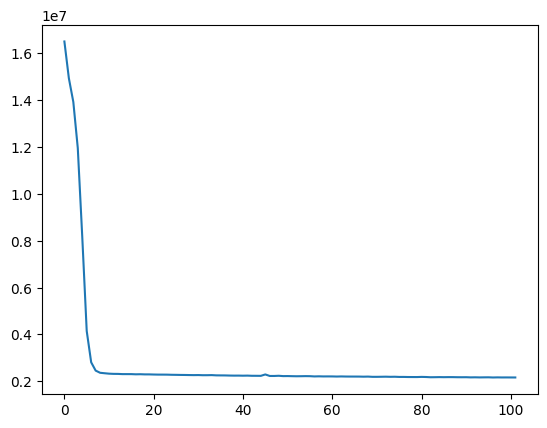

In [72]:
plt.plot(loss_list)

## Старое решение через инструменты ML  

In [445]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset

import torch
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [407]:
data = pd.read_csv('diamonds.csv').iloc[:, 1:] # убираем первую не нужную колонку 

data.head(3)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


### Primary analysis

In [408]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [409]:
data.isna().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

In [410]:
data.select_dtypes(exclude=object).describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [411]:
data.select_dtypes(include=object).describe()

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


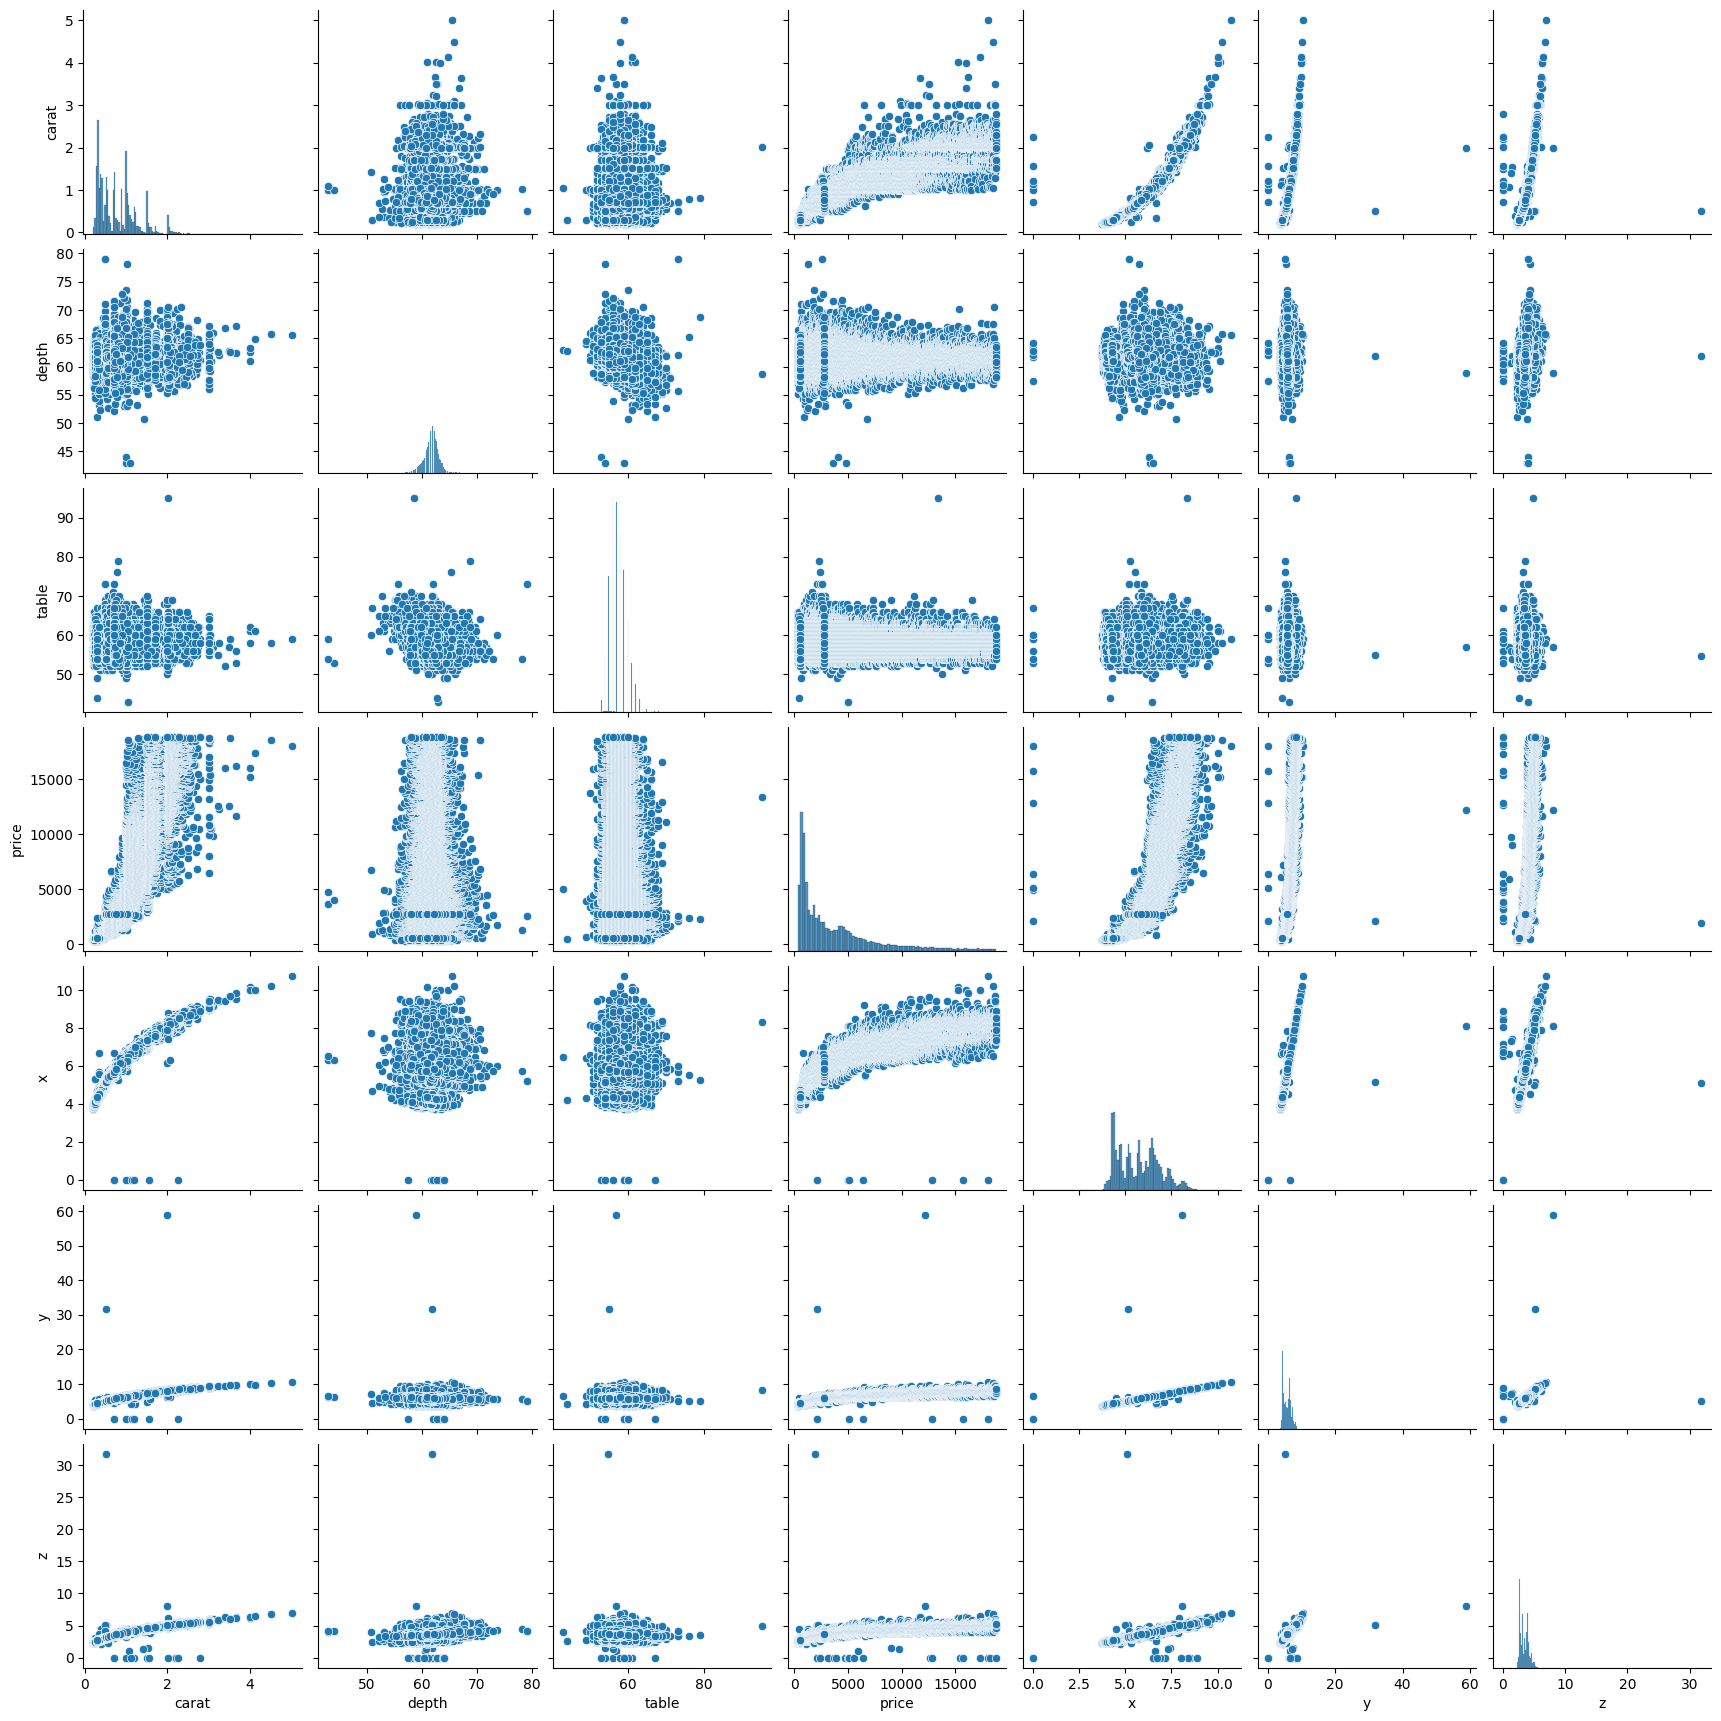

In [412]:
sns.pairplot(data)

<Axes: >

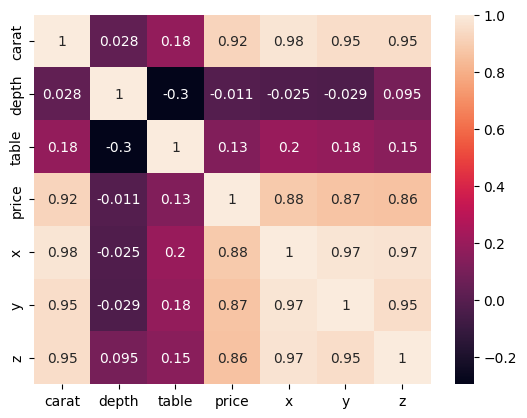

In [413]:
sns.heatmap(data.select_dtypes(exclude=object).corr(),annot=True)

#### Result of Primary analysis

1. Из описания данных (https://www.kaggle.com/datasets/shivam2503/diamonds/data) узнаем, что depth = 2* z / (x + y)
2. Нет пропущенных значений
3. Есть выбросы
4. Не все признаки распределены нормально
5. Данные плохо перемешаны
6. Есть необходимость в дамми переменных 

## Feature Engineering

#### Выбросы (работаю только с нужными перспективными признаками)

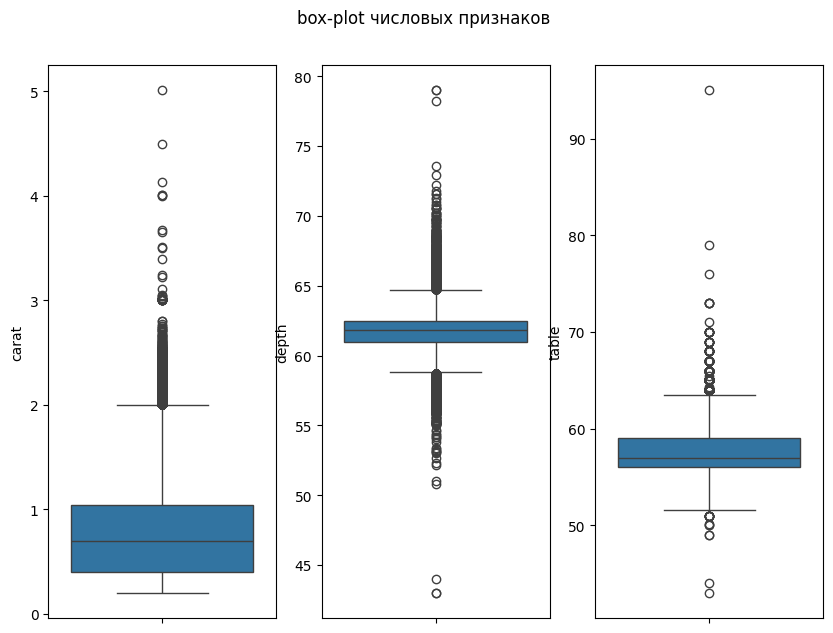

In [414]:
fig, axes = plt.subplots(1,3,figsize=(10,7))


plt.suptitle('box-plot числовых признаков')
plt.subplots_adjust(top=0.9) # отступ для заголовка

sns.boxplot(data, y='carat', ax=axes[0])
sns.boxplot(data, y='depth', ax=axes[1])
sns.boxplot(data, y='table', ax=axes[2])


plt.show()

In [415]:
data.shape

(53940, 10)

##### Выбросов много :(

In [416]:
columnnum = data.select_dtypes(exclude='object')[['carat', 'depth', 'table']] # выбираем числовые признаки

dd = dict() # словарь с нижней границей выбросов
du = dict() # словарь с верхней границей выбросов

for name in columnnum:
    '''[𝑥25−1,5 ∙ 𝑥75 − 𝑥25 ; 𝑥75 + 1,5 ∙ (𝑥75 − 𝑥25)]'''
    Q1, Q3 = data[name].quantile([0.25, 0.75])
    down = Q1 - 1.5 * (Q3 - Q1) # формула нижней границы
    up = Q3 + 1.5 * (Q3 - Q1) # формула верхней границы

    
    dd[name] =  [down]
    du[name] = [up]
    
emission = pd.concat([pd.DataFrame(dd), pd.DataFrame(du)]).T # добавляем в один датафрейм нижние и верхние границы
emission.columns = ['down', 'up'] # переименовываем столбцы
emission

,down,up
carat,-0.56,2.00
depth,58.75,64.75
table,51.50,63.50


In [417]:
for name in columnnum:
    arr = data[name]
    data.loc[:, name][(data[name] < emission['down'][name])] = np.NaN
    data.loc[:, name][(data[name] > emission['up'][name])] = np.NaN

In [418]:
data.isna().any()

carat       True
cut        False
color      False
clarity    False
depth       True
table       True
price      False
x          False
y          False
z          False
dtype: bool

In [419]:
data = data.dropna()

In [420]:
data.shape

(49320, 10)

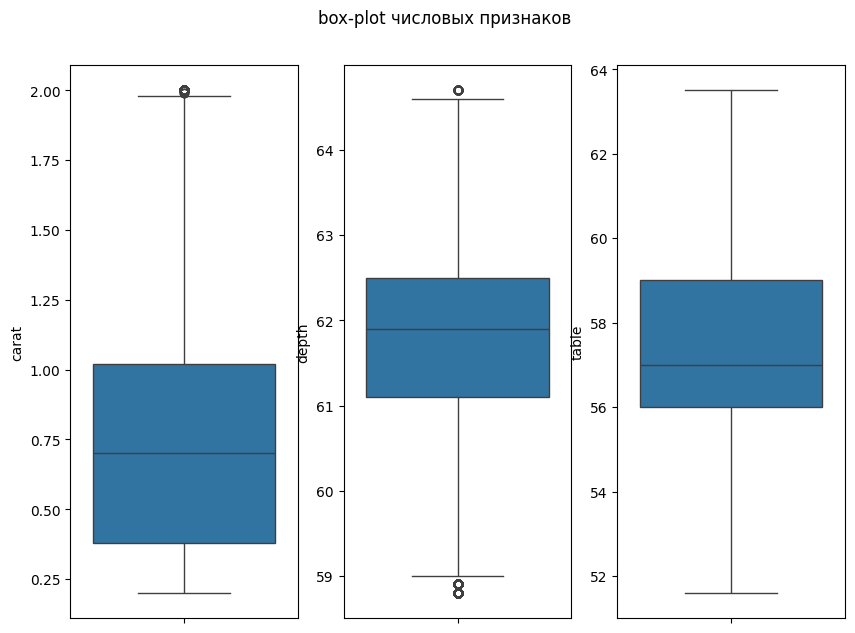

In [421]:
fig, axes = plt.subplots(1,3,figsize=(10,7))


plt.suptitle('box-plot числовых признаков')
plt.subplots_adjust(top=0.9) # отступ для заголовка

sns.boxplot(data, y='carat', ax=axes[0])
sns.boxplot(data, y='depth', ax=axes[1])
sns.boxplot(data, y='table', ax=axes[2])


plt.show()

In [422]:
data.shape

(49320, 10)

### Работа с числовыми признаками 

- depth имеет функциональную связь с z, x, y, следуя описанию задачи  
- Есть аномальные значения

In [423]:
data = data.drop(columns=['x', 'y', 'z'])
data

,carat,cut,color,clarity,depth,table,price
0,0.23,Ideal,E,SI2,61.5,55.0,326
1,0.21,Premium,E,SI1,59.8,61.0,326
3,0.29,Premium,I,VS2,62.4,58.0,334
4,0.31,Good,J,SI2,63.3,58.0,335
5,0.24,Very Good,J,VVS2,62.8,57.0,336
...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757
53936,0.72,Good,D,SI1,63.1,55.0,2757
53937,0.70,Very Good,D,SI1,62.8,60.0,2757
53938,0.86,Premium,H,SI2,61.0,58.0,2757


In [424]:
dataNum = data.select_dtypes(exclude=object)
dataNum.head(3)

,carat,depth,table,price
0,0.23,61.5,55.0,326
1,0.21,59.8,61.0,326
3,0.29,62.4,58.0,334


In [425]:
dataNum.describe()

,carat,depth,table,price
count,49320.000000,49320.000000,49320.000000,49320.000000
mean,0.740327,61.783976,57.269864,3514.735320
std,0.401263,1.106932,2.019441,3431.481469
min,0.200000,58.800000,51.600000,326.000000
25%,0.380000,61.100000,56.000000,908.750000
50%,0.700000,61.900000,57.000000,2215.000000
75%,1.020000,62.500000,59.000000,4964.000000
max,2.000000,64.700000,63.500000,18818.000000


### MinMaxNScaler

In [426]:
num = data.select_dtypes(exclude=object).drop(columns=['price']).columns
model = MinMaxScaler()
data[num] = model.fit_transform(data[num].to_numpy())
data

,carat,cut,color,clarity,depth,table,price
0,0.016667,Ideal,E,SI2,0.457627,0.285714,326
1,0.005556,Premium,E,SI1,0.169492,0.789916,326
3,0.050000,Premium,I,VS2,0.610169,0.537815,334
4,0.061111,Good,J,SI2,0.762712,0.537815,335
5,0.022222,Very Good,J,VVS2,0.677966,0.453782,336
...,...,...,...,...,...,...,...
53935,0.288889,Ideal,D,SI1,0.338983,0.453782,2757
53936,0.288889,Good,D,SI1,0.728814,0.285714,2757
53937,0.277778,Very Good,D,SI1,0.677966,0.705882,2757
53938,0.366667,Premium,H,SI2,0.372881,0.537815,2757


### Работа с категориальными признаками

In [427]:
dataCat = data.select_dtypes(include=object)
dataCat.head(3)

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
3,Premium,I,VS2


In [428]:
col = data.select_dtypes(include=object).columns.to_list()
col

['cut', 'color', 'clarity']

In [429]:
for name in dataCat.columns:
    print(dataCat[name].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS2' 'VVS2' 'VVS1' 'VS1' 'I1' 'IF']


In [430]:
data = pd.get_dummies(data, drop_first=True, dtype=float, columns=col)
data

,carat,depth,table,price,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.016667,0.457627,0.285714,326,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.005556,0.169492,0.789916,326,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.050000,0.610169,0.537815,334,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.061111,0.762712,0.537815,335,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.022222,0.677966,0.453782,336,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.288889,0.338983,0.453782,2757,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,0.288889,0.728814,0.285714,2757,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,0.277778,0.677966,0.705882,2757,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,0.366667,0.372881,0.537815,2757,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Работа с train, test 

In [435]:
X = torch.tensor(data.drop(columns=['price']).to_numpy(), dtype=torch.float)
y = torch.tensor(data['price'].to_numpy(), dtype = torch.float).reshape(-1, 1)
X

tensor([[0.0167, 0.4576, 0.2857,  ..., 0.0000, 0.0000, 0.0000],
        [0.0056, 0.1695, 0.7899,  ..., 0.0000, 0.0000, 0.0000],
        [0.0500, 0.6102, 0.5378,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.2778, 0.6780, 0.7059,  ..., 0.0000, 0.0000, 0.0000],
        [0.3667, 0.3729, 0.5378,  ..., 0.0000, 0.0000, 0.0000],
        [0.3056, 0.5763, 0.2857,  ..., 0.0000, 0.0000, 0.0000]])

In [436]:
y

tensor([[ 326.],
        [ 326.],
        [ 334.],
        ...,
        [2757.],
        [2757.],
        [2757.]])

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [441]:
X_train.shape, X_test.shape

(torch.Size([34524, 20]), torch.Size([14796, 20]))

In [443]:
y_train.shape, y_test.shape

(torch.Size([34524, 1]), torch.Size([14796, 1]))

In [464]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

## Quickly Starter 

In [518]:
model = nn.Sequential(
    
    nn.Linear(X.shape[1], 40),
    nn.ReLU(),
    nn.Linear(40, 1)
    
)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)
crit = nn.MSELoss()
loss_list = []

In [519]:
for epoch in range(1_000 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = model(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 200 == 0:
        y_test_pred = model(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    
        
    

0 --loss--> 23826292.0 --test_loss--> 23034320.0
200 --loss--> 282091.71875 --test_loss--> 301146.84375
400 --loss--> 245506.09375 --test_loss--> 261935.171875
600 --loss--> 229767.46875 --test_loss--> 244152.109375
800 --loss--> 221780.828125 --test_loss--> 237720.15625
1000 --loss--> 218071.375 --test_loss--> 233503.0


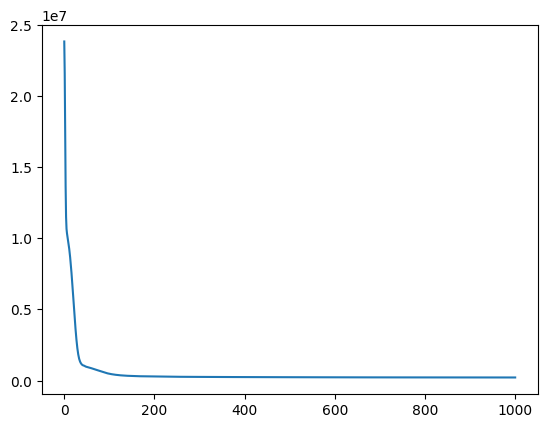

In [520]:
plt.plot(loss_list)

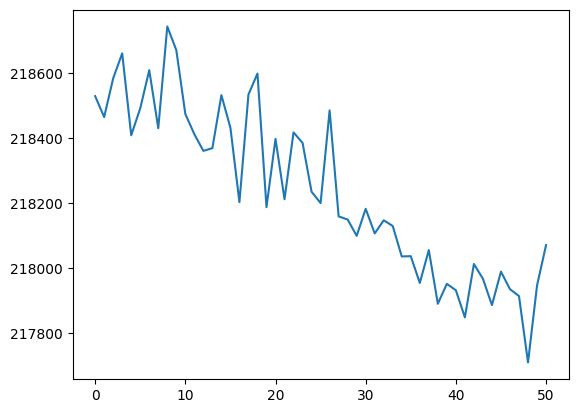

In [521]:
plt.plot(loss_list[950:])

### ADAM 6 LINEAR 3 RELU 1 DROPOUT (0.6) 

In [522]:
model = nn.Sequential(
    
    nn.Linear(X.shape[1], 60),
    nn.ReLU(),
    nn.Linear(60, 60),
    nn.Dropout(p=0.6),
    nn.Linear(60, 30), 
    nn.ReLU(),
    nn.Linear(30, 25),
    nn.ReLU(),
    nn.Linear(25, 10),
    nn.Linear(10,1)
    
    
    
)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
crit = nn.MSELoss()
loss_list = []

In [523]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = model(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = model(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 19392642.0 --test_loss--> 10596931.0
100 --loss--> 309721.6875 --test_loss--> 338079.90625
200 --loss--> 260138.1875 --test_loss--> 286580.96875
300 --loss--> 242989.625 --test_loss--> 275511.09375
400 --loss--> 231789.359375 --test_loss--> 277065.59375
500 --loss--> 236901.390625 --test_loss--> 255021.15625


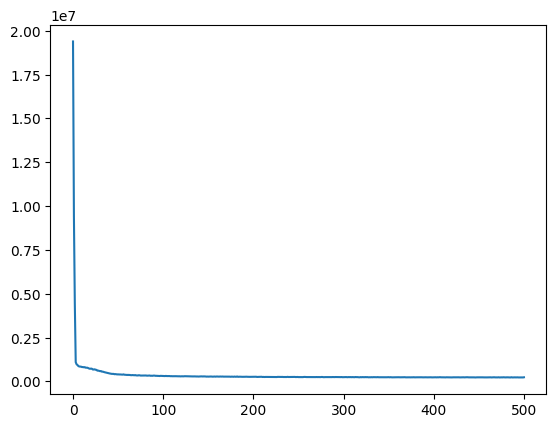

In [524]:
plt.plot(loss_list)

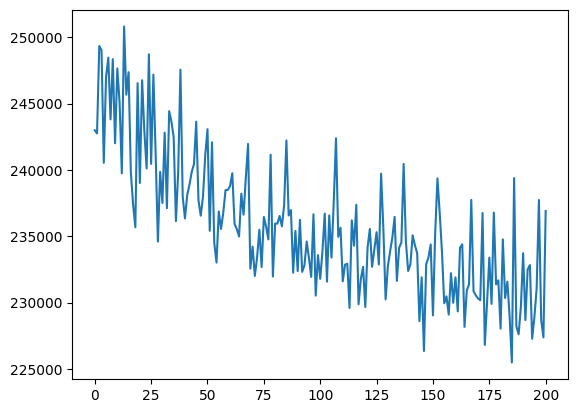

In [527]:
plt.plot(loss_list[300:])

### Сравниваем quick start с разными алгоритмами 

In [550]:
# изменил немного архитектуру 

model = nn.Sequential(
    
    nn.Linear(X.shape[1], 80),
    nn.ReLU(),
    nn.Linear(80, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [551]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [552]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = model(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = model(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 61888688.0 --test_loss--> 20304204.0
100 --loss--> 11768525.0 --test_loss--> 11787379.0
200 --loss--> 11769414.0 --test_loss--> 11787369.0
300 --loss--> 11771121.0 --test_loss--> 11787401.0
400 --loss--> 11769304.0 --test_loss--> 11787422.0
500 --loss--> 11770169.0 --test_loss--> 11787371.0


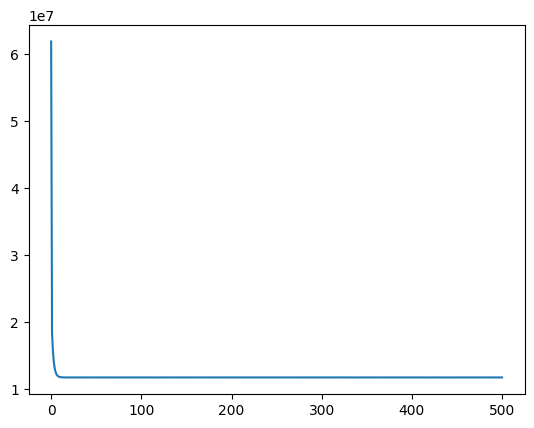

In [553]:
plt.plot(loss_list)

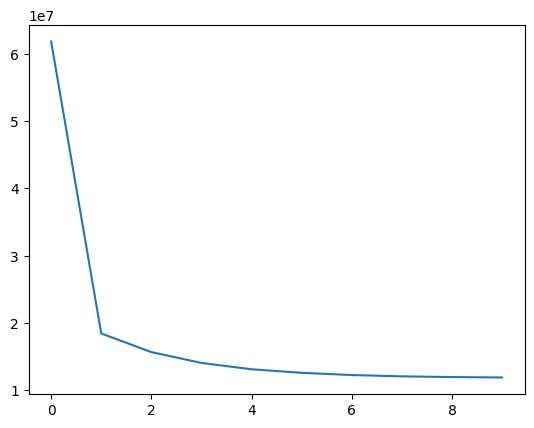

In [561]:
plt.plot(loss_list[:10])

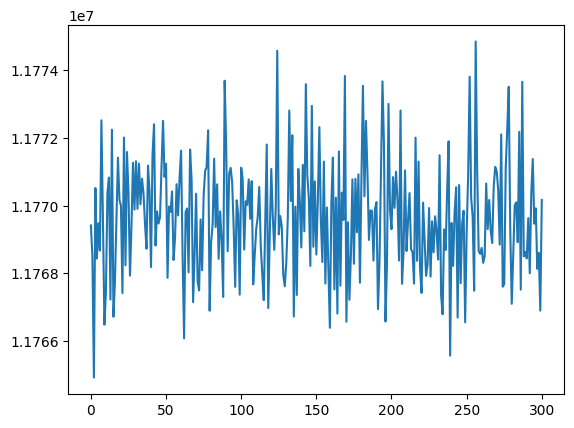

In [562]:
plt.plot(loss_list[200:])

In [563]:
modelS2 = nn.Sequential(
    
    nn.Linear(X.shape[1], 80),
    nn.ReLU(),
    nn.Linear(80, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [564]:
opt = torch.optim.SGD(modelS2.parameters(), lr=0.1)

In [565]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelS2(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelS2(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 148852432.0 --test_loss--> 11787752.0
100 --loss--> 11777070.0 --test_loss--> 11790957.0
200 --loss--> 11779657.0 --test_loss--> 11799091.0
300 --loss--> 11776840.0 --test_loss--> 11800607.0
400 --loss--> 11779074.0 --test_loss--> 11787654.0
500 --loss--> 11773577.0 --test_loss--> 11787392.0


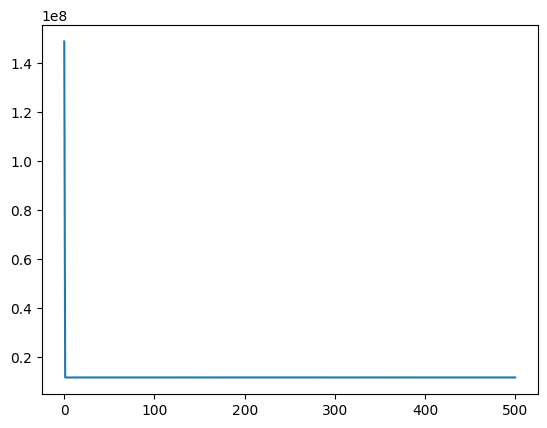

In [566]:
plt.plot(loss_list)

Попытка на моментуме 

In [570]:
modelSM = nn.Sequential(
    
    nn.Linear(X.shape[1], 80),
    nn.ReLU(),
    nn.Linear(80, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [571]:
opt = torch.optim.SGD(modelSM.parameters(), momentum=.9, lr=0.001)

In [572]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelSM(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelSM(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 46912176.0 --test_loss--> 11836921.0
100 --loss--> 11772788.0 --test_loss--> 11787253.0
200 --loss--> 11768682.0 --test_loss--> 11787287.0
300 --loss--> 11768688.0 --test_loss--> 11787655.0
400 --loss--> 11768331.0 --test_loss--> 11788095.0
500 --loss--> 11768531.0 --test_loss--> 11787265.0


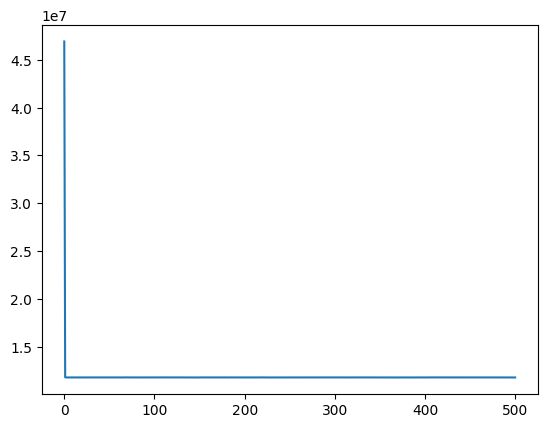

In [573]:
plt.plot(loss_list)

вторая попытка

In [574]:
modelSM2 = nn.Sequential(
    
    nn.Linear(X.shape[1], 80),
    nn.ReLU(),
    nn.Linear(80, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [576]:
opt = torch.optim.SGD(modelSM2.parameters(), momentum=.75, lr=0.001)

In [577]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelSM2(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelSM2(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 17335460.0 --test_loss--> 13271567.0
100 --loss--> 11766976.0 --test_loss--> 11787421.0
200 --loss--> 11772078.0 --test_loss--> 11787373.0
300 --loss--> 11772409.0 --test_loss--> 11787356.0
400 --loss--> 11769568.0 --test_loss--> 11787279.0
500 --loss--> 11768072.0 --test_loss--> 11787264.0


In [581]:
modelSM3 = nn.Sequential(
    
    nn.Linear(X.shape[1], 40),
    nn.ReLU(),
    nn.Linear(40, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [582]:
opt = torch.optim.SGD(modelSM3.parameters(), momentum=.75, lr=0.001)

In [583]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelSM3(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelSM3(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 55410544.0 --test_loss--> 13721769.0
100 --loss--> 11769252.0 --test_loss--> 11787430.0
200 --loss--> 11769216.0 --test_loss--> 11787353.0
300 --loss--> 11768016.0 --test_loss--> 11787347.0
400 --loss--> 11769843.0 --test_loss--> 11787322.0
500 --loss--> 11768056.0 --test_loss--> 11787497.0


In [588]:
modelAD = nn.Sequential(
    
    nn.Linear(X.shape[1], 40),
    nn.ReLU(),
    nn.Linear(40, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [589]:
opt = torch.optim.Adagrad(modelAD.parameters(), lr=0.001)

In [590]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelAD(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelAD(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 24146962.0 --test_loss--> 24079252.0
100 --loss--> 24015336.0 --test_loss--> 23951948.0
200 --loss--> 23896002.0 --test_loss--> 23828358.0
300 --loss--> 23768928.0 --test_loss--> 23702746.0
400 --loss--> 23638888.0 --test_loss--> 23575052.0
500 --loss--> 23517928.0 --test_loss--> 23448738.0


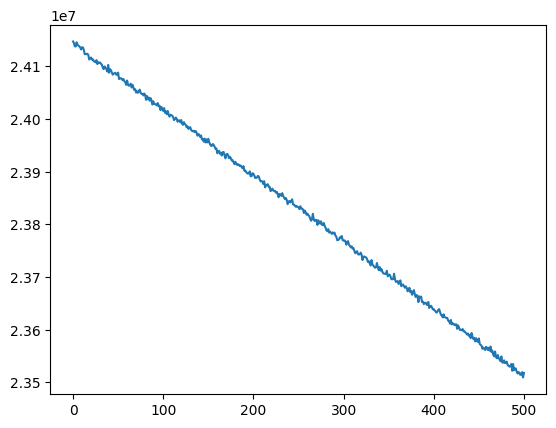

In [591]:
plt.plot(loss_list)

In [592]:
modelADAM = nn.Sequential(
    
    nn.Linear(X.shape[1], 40),
    nn.ReLU(),
    nn.Linear(40, 1)
    
)
crit = nn.MSELoss()
loss_list = []

In [593]:
opt = torch.optim.Adam(modelADAM.parameters(), lr=0.001)

In [594]:
for epoch in range(500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelADAM(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelADAM(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 24133688.0 --test_loss--> 24048114.0
100 --loss--> 5329608.5 --test_loss--> 5301925.0
200 --loss--> 1165997.75 --test_loss--> 1161964.5
300 --loss--> 1141232.25 --test_loss--> 1138060.875
400 --loss--> 1029767.0 --test_loss--> 1028433.0625
500 --loss--> 933957.625 --test_loss--> 934536.9375


In [602]:
modelADAMtop = nn.Sequential(
    
    nn.Linear(X.shape[1], 180),
    nn.ReLU(),
    nn.Linear(180, 60),
    nn.Dropout(0.4),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 15), 
    nn.BatchNorm1d(15),
    nn.Linear(15, 5),
    nn.Linear(5,1)
    
    
)
crit = nn.MSELoss()
loss_list = []

In [603]:
opt = torch.optim.Adam(modelADAMtop.parameters(), lr=0.001)

In [604]:
for epoch in range(1500 + 1):
    batch_loss = []
    for i, (x, y_) in enumerate(dataloader):
        y_hat = modelADAMtop(x)
        
        curr_loss = criterion(y_hat, y_)
        
        curr_loss.backward()
        opt.step()
        opt.zero_grad()
        
        batch_loss.append(curr_loss.item())
    
    loss_list.append(torch.tensor(batch_loss).mean())
    
    if epoch % 100 == 0:
        y_test_pred = modelADAMtop(X_test)
        print(f'{epoch} --loss--> {torch.tensor(batch_loss).mean()} --test_loss--> {criterion(y_test_pred, y_test).item()}')
    

0 --loss--> 24120814.0 --test_loss--> 24016632.0
100 --loss--> 263549.90625 --test_loss--> 259522.0625
200 --loss--> 239983.71875 --test_loss--> 242686.375
300 --loss--> 222294.15625 --test_loss--> 239385.6875
400 --loss--> 219181.515625 --test_loss--> 249016.296875
500 --loss--> 214104.421875 --test_loss--> 240920.109375
600 --loss--> 202200.796875 --test_loss--> 245070.546875
700 --loss--> 207807.453125 --test_loss--> 250044.515625
800 --loss--> 200500.34375 --test_loss--> 249496.3125
900 --loss--> 200193.734375 --test_loss--> 244580.921875
1000 --loss--> 206625.1875 --test_loss--> 252862.4375
1100 --loss--> 182360.453125 --test_loss--> 252810.21875
1200 --loss--> 194861.84375 --test_loss--> 259157.28125
1300 --loss--> 192392.546875 --test_loss--> 260401.96875
1400 --loss--> 191176.46875 --test_loss--> 252497.875
1500 --loss--> 187600.109375 --test_loss--> 250153.15625


In [607]:
from sklearn.metrics import mean_absolute_error, r2_score

## Метрики лучшей модели 

In [610]:
print(f'train mae -> {mean_absolute_error(y_train, modelADAMtop(X_train).detach())}')
print(f'test mae -> {mean_absolute_error(y_test, modelADAMtop(X_test).detach())}')

train mae -> 220.8079833984375
test mae -> 271.8470458984375


In [611]:
print(f'train r2 -> {r2_score(y_train, modelADAMtop(X_train).detach())}')
print(f'test r2 -> {r2_score(y_test, modelADAMtop(X_test).detach())}')

train r2 -> 0.9888398440717496
test r2 -> 0.9782669635762336


Можно улучшить модель нормировав целевую переменную.